In [1]:
import os
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import time
from datetime import timedelta
import h5py
from tqdm import tqdm
import argparse
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

import sys

ProjectPath = "/home/liranc6/ecg_forecasting" #os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
sys.path.append(ProjectPath)  # Add the parent directory to the sys.path

import liran_project.utils.dataset_loader as dataset_loader

# import liran_project.train as liran_train
from liran_project.utils.dataset_loader import SingleLeadECGDatasetCrops
from liran_project.utils.util import modify_z_and_omega

sys.path.append('/home/liranc6/ecg_forecasting/SSSD_main')

from SSSD_main.src.utils.util import find_epoch, print_size, sampling, calc_diffusion_hyperparams
from SSSD_main.src.utils.util import get_mask_mnr, get_mask_bm, get_mask_rm, get_mask_pred

import SSSD_main.src.utils.util as util
from SSSD_main.src.imputers.DiffWaveImputer import DiffWaveImputer
from SSSD_main.src.imputers.SSSDSAImputer import SSSDSAImputer
from SSSD_main.src.imputers.SSSDS4Imputer import SSSDS4Imputer

from sklearn.metrics import mean_squared_error
from statistics import mean

/home/liranc6/miniconda3/envs/ecg/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.


In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

! gpustat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

chuck2                    Mon Jul  1 14:38:46 2024  535.183.01
[0] NVIDIA A100-SXM4-80GB | 36°C,   0 % |     0 / 81920 MB |
device=device(type='cuda')


In [3]:
torch.manual_seed(123)

In [4]:
config_file = "/home/liranc6/ecg_forecasting/SSSD_main/src/config/train_config.json"
with open(config_file) as f:
    data = f.read()
config = json.loads(data)

gen_config = config['gen_config']

train_config =  config["train_config"]  # training parameters
gen_config = config["gen_config"]

model_name = gen_config["model_name"]

In [5]:
global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(**diffusion_config)  # dictionary of all diffusion hyperparameters

# global model_config
# if train_config['use_model'] == 0:
#     model_config = config['wavenet_config']
# elif train_config['use_model'] == 1:
#     model_config = config['sashimi_config']
# elif train_config['use_model'] == 2:
#     model_config = config['wavenet_config']

In [6]:
# split the windows to fixed size context and label windows
fs, context_num_minutes, context_num_secondes, label_window_num_minutes, label_window_num_secondes = config['window_info'].values()

context_window_size = (context_num_minutes*60 + context_num_secondes) * fs  # minutes * seconds * fs
label_window_size = (label_window_num_minutes*60 + label_window_num_secondes) * fs  # minutes * seconds * fs
window_size = context_window_size+label_window_size

if model_name == "SSSDSA":
    context_window_size -= (context_window_size%4) # patch bug fix for SSSDSA impputator forward, the input size should be divisible by 4
    label_window_size -= (label_window_size%4)

server = "newton"
idx_start_val = 33
idx_start_test = 40
idx_end_test = 46

data_path = config["trainset_config"][f"data_path_{server}"]

train_file = os.path.join(data_path,
                            "train",
                            f'p0_to_p{idx_start_val-1}.h5')

val_file = os.path.join(data_path,
                            "val",
                            f'p{idx_start_val}_to_p{idx_start_test-1}.h5')
test_file = os.path.join(data_path,
                            "test",
                            f'p{idx_start_test}_to_p{idx_end_test}.h5')
    
ten_minutes_window_file = train_file

# Instantiate the class
dataset = dataset_loader.SingleLeadECGDatasetCrops(context_window_size, label_window_size, ten_minutes_window_file, end_patiant=10)

key='00000'
key='00001'
key='00002'
key='00003'
key='00004'
key='00005'
key='00006'
key='00007'
key='00008'
key='00009'


In [7]:
# def generate(output_directory,
#             num_samples,
#             ckpt_path,
#             data_path,
#             ckpt_iter,
#             use_model,
#             masking,
#             missing_k,
#             only_generate_missing,
#             context_size,
#             label_size,
#             batch_size,
#             **kwargs):
    
#     """
#     Generate data based on ground truth 

#     Parameters:
#     output_directory (str):           save generated speeches to this path
#     num_samples (int):                number of samples to generate, default is 4
#     ckpt_path (str):                  checkpoint path
#     ckpt_iter (int or 'max'):         the pretrained checkpoint to be loaded; 
#                                       automitically selects the maximum iteration if 'max' is selected
#     data_path (str):                  path to dataset, numpy array.
#     use_model (int):                  0:DiffWave. 1:SSSDSA. 2:SSSDS4.
#     masking (str):                    'mnr': missing not at random, 'bm': black-out, 'rm': random missing
#     only_generate_missing (int):      0:all sample diffusion.  1:only apply diffusion to missing portions of the signal
#     missing_k (int)                   k missing time points for each channel across the length.
#     """

#     # generate experiment (local) path
#     window_info = "context{}_label{}".format(context_size, label_size)
#     local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
#                                               diffusion_config["beta_0"],
#                                               diffusion_config["beta_T"])

#     # # Get shared output_directory ready
#     # output_directory = os.path.join(output_directory,
#     #                                 window_info,
#     #                                  local_path)
#     # if not os.path.isdir(output_directory):
#     #     os.makedirs(output_directory)
#     #     os.chmod(output_directory, 0o775)
#     # print("output directory", output_directory, flush=True)

#     # map diffusion hyperparameters to gpu
#     for key in diffusion_hyperparams:
#         if key != "T":
#             diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    
#     # predefine model
#     if use_model == 0:
#         net = DiffWaveImputer(**model_config).cuda()
#     elif use_model == 1:
#         net = SSSDSAImputer(**model_config).cuda()
#     elif use_model == 2:
#         net = SSSDS4Imputer(**model_config).cuda()
#     else:
#         print('Model chosen not available.')
#     print_size(net)

#     # adjust model architecture to the one saved in the checkpoint
    

    
#     # load checkpoint
#     ckpt_path = os.path.join(ckpt_path, 
#                              window_info,
#                              local_path)
#     if ckpt_iter == 'max':
#         ckpt_iter = find_epoch(ckpt_path)
#     model_path = os.path.join(ckpt_path, '{}.pkl'.format(ckpt_iter))
#     checkpoint = torch.load(model_path, map_location='cpu')
#     try:
#         # new_shapes_omega = checkpoint['model_state_dict']['residual_layer.residual_blocks.35.S42.s4_layer.kernel.kernel.omega'].size #(new_rows_omega, new_cols_omega)
#         # new_shapes_z =  checkpoint['model_state_dict']['residual_layer.residual_blocks.35.S42.s4_layer.kernel.kernel.z'].size #(new_rows_z, new_cols_z)
#         # print(f"{new_shapes_omega=}, ")
#         # net.residual_layer.residual_blocks[35].S42.s4_layer.kernel.kernel.z = checkpoint['model_state_dict']['residual_layer.residual_blocks.35.S42.s4_layer.kernel.kernel.z'].to(device)
#         net.load_state_dict(checkpoint['model_state_dict'], strict=False)
#         print('Successfully loaded model at iteration {}'.format(ckpt_iter))
#     except Exception as e:
#         print(f"{e=}")
#         raise Exception('No valid model found')

        
        
#     ### Custom data loading and reshaping ###
    
#     # testing_data = np.load(trainset_config['test_data_path'])
#     # testing_data = np.split(testing_data, 4, 0)
#     # testing_data = np.array(testing_data)
#     # testing_data = torch.from_numpy(testing_data).float().cuda()


#      # Specify the path to the H5 file
#     file_path = data_path
#     # Load data from the first dataset
#     dataset = SingleLeadECGDatasetCrops(context_size, label_size, file_path)
#     # Use DataLoader to handle batching and shuffling
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


#     print('Data loaded')

#     all_mse = []

    
#     for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), position=0, leave=True, dynamic_ncols=True):

#         if i > 0:
#             break
        
#         original_batch = torch.cat(batch, dim=-1).unsqueeze(0)[:, :, :].permute(1,0,2).float()
#         # create a zero tensore with the same size as batch[1]
#         to_pred = torch.zeros(batch[1].size())

#         #concat batch[0] and pred
#         batch = torch.cat((batch[0], to_pred), dim=1).unsqueeze(0)[:, :, :].float().to(device)

#         if masking == 'mnr':
#             mask_T = get_mask_mnr(batch[0], missing_k)
#             mask = mask_T.permute(1, 0)
#             mask = mask.repeat(batch.size()[0], 1, 1)
#             mask = mask.type(torch.float).cuda()

#         elif masking == 'bm':
#             mask_T = get_mask_bm(batch[0], missing_k)
#             mask = mask_T.permute(1, 0)
#             mask = mask.repeat(batch.size()[0], 1, 1)
#             mask = mask.type(torch.float).cuda()

#         elif masking == 'rm':
#             mask_T = get_mask_rm(batch[0], missing_k)
#             mask = mask_T.permute(1, 0)
#             mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()

#         ##pred mask
#         elif masking == 'pred':
#             mask = get_mask_pred(batch[0], context_size=context_size, pred_size=label_size)
#             # mask = mask.permute(1, 0) #?
#             mask = mask.repeat(batch.size()[0], 1, 1).float().cuda() #?

#         # tqdm.write(f"{mask.shape=}")
            
#         batch = batch.permute(1,0,2)
#         mask = mask.permute(1,0,2)
        
#         start = torch.cuda.Event(enable_timing=True)
#         end = torch.cuda.Event(enable_timing=True)
#         start.record()

#         generated_audio = sampling(net, 
#                                    size=batch.size(),
#                                    diffusion_hyperparams=diffusion_hyperparams,
#                                    cond=batch,
#                                    mask=mask,
#                                    only_generate_missing=only_generate_missing)

#         end.record()
#         torch.cuda.synchronize()

#         print('generated {} utterances of random_digit at iteration {} in {} seconds'.format(num_samples,
#                                                                                              ckpt_iter,
#                                                                                              int(start.elapsed_time(
#                                                                                                  end) / 1000)))

        
#         batch = original_batch
#         generated_audio = generated_audio.detach().cpu().numpy()
#         batch = batch.detach().cpu().numpy()
#         mask = mask.detach().cpu().numpy() 
        
        
#         outfile = f'imputation{i}.npy'
#         new_out = os.path.join(ckpt_path, outfile)
#         np.save(new_out, generated_audio)

#         outfile = f'original{i}.npy'
#         new_out = os.path.join(ckpt_path, outfile)
#         np.save(new_out, batch)

#         outfile = f'mask{i}.npy'
#         new_out = os.path.join(ckpt_path, outfile)
#         np.save(new_out, mask)

#         print('saved generated samples at iteration %s' % ckpt_iter)
        
#         mse = mean_squared_error(generated_audio[~mask.astype(bool)], batch[~mask.astype(bool)])
#         all_mse.append(mse)
    
#     print('Total MSE:', mean(all_mse))


In [8]:
#open the file
patient_id = 2
sample_num = 0
num_samples = 10
data = None
advance = 5*(context_window_size+label_window_size)
with h5py.File(ten_minutes_window_file, 'r') as f:
    # take the {sample_num} from the {patient_id}
    # hint: f'p{patient_id:05d}'[:3]
    data = f[f'{patient_id:05d}'][:][sample_num:sample_num+num_samples, advance:]
    data = torch.from_numpy(data)

data.size()

torch.Size([10, 0, 150000])

In [9]:
def one_step_predictor(net, context, step_size, diffusion_hyperparams, only_generate_missing):
    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key != "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    # #check if context is tensor, if not convert to tensor
    # if not isinstance(context, torch.Tensor):
    #     context = torch.tensor(context)
    
    mask = F.pad(torch.ones_like(context), pad=[0, step_size], mode='constant', value=0).unsqueeze(1).float().cuda()

    window = F.pad(context, pad=[0, step_size], mode='constant', value=0).unsqueeze(1).float().cuda()

    # to_pred_unsqueeze = to_pred.unsqueeze(0).unsqueeze(0).float().cuda()

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    generated_audio = sampling(net, 
                            size=window.size(),
                            diffusion_hyperparams=diffusion_hyperparams,
                            cond=window,
                            mask=mask,
                            only_generate_missing=only_generate_missing)

    end.record()
    torch.cuda.synchronize()

    generated_audio = generated_audio.detach().cpu()

    return generated_audio
  
def autoegressive_predictor(config_file, ckpt_path, ckpt_iter, context, label_size, step_size, num_window_to_pred, diffusion_hyperparams, only_generate_missing, specific_chpt_path=None):

    # Get shared output_directory ready
    # output_directory = os.path.join(output_directory,
    #                                 window_info,
    #                                  local_path)
    
    # if not os.path.isdir(output_directory):
    #     os.makedirs(output_directory)
    #     os.chmod(output_directory, 0o775)
    # print("output directory", output_directory, flush=True)


    with open(config_file) as f:
        data = f.read()
    
    config = json.loads(data)

    print(f"{torch.cuda.is_available()=}")
    # map diffusion hyperparameters to gpu
    for key in diffusion_hyperparams:
        if key != "T":
            diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()

    model_name = config["gen_config"]["model_name"]

    model_config_path = os.path.join(config["train_config"]["model_config_path"], f"config_{model_name}.json")

    with open(model_config_path) as f:
        config_SSSD_inner_model = json.load(f)
    inner_model_config = config_SSSD_inner_model['sashimi_config']

    if model_name == "SSSDS4":
        net = SSSDS4Imputer(**inner_model_config).cuda()
    elif model_name == "SSSDSA":
        net = SSSDSAImputer(**inner_model_config).cuda()
    else:
        raise ValueError(f"model_name should be either 'SSSDS4' or 'SSSDSA', but got {model_name}")

        
    print_size(net)

    if specific_chpt_path:
        try:
            checkpoint = torch.load(specific_chpt_path, map_location='cpu')
            modify_z_and_omega(net, model_name, checkpoint, device)
            net.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print('Successfully loaded model from specific_chpt_path')
        except Exception as e:
            print(f"{e=}")
            raise Exception('specific_chpt_path not valid')
    else:
        window_info = "context{}_label{}".format(len(context.size()[-1]), label_size)
        local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])
        # load checkpoint
        ckpt_path = os.path.join(ckpt_path, 
                                window_info,
                                local_path)
        if ckpt_iter == 'max':
            ckpt_iter = find_epoch(ckpt_path)
        model_path = os.path.join(ckpt_path, '{}.pkl'.format(ckpt_iter))
        checkpoint = torch.load(model_path, map_location='cpu')
        try:
            net.load_state_dict(checkpoint['model_state_dict'], strict=False)
            print('Successfully loaded model at iteration {}'.format(ckpt_iter))
        except Exception as e:
            print(f"{e=}")
            raise Exception('No valid model found')

    if not isinstance(context, torch.Tensor):
        context = torch.tensor(context)
    full_gen = context

    predictions = {}
    for i in tqdm(range(num_window_to_pred), position=0, leave=True, dynamic_ncols=True):
        generated_ecg = one_step_predictor(net = net,
                                            context = context,
                                            step_size = step_size,
                                            diffusion_hyperparams = diffusion_hyperparams,
                                            only_generate_missing = only_generate_missing
                                            )
        
        generated_ecg = generated_ecg.squeeze(1)
        full_gen = torch.cat((full_gen, generated_ecg[..., -step_size:]), dim=-1)
        context = generated_ecg[..., step_size:]

        predictions[i] = generated_ecg        

        tqdm.write(f"{full_gen.size=}")

    for i in range(len(predictions)):
        current_date_and_time = str(time.strftime("%Y-%m-%d_%H-%M-%S"))
        outfile = f'imputation{i}_{current_date_and_time}.npy'
        output_dir = os.path.join(ckpt_path, "imputations")
        os.makedirs(output_dir, exist_ok=True)
        new_out = os.path.join(ckpt_path, "imputations", outfile)
        np.save(new_out, generated_ecg.numpy())
            
    return full_gen


In [13]:
if torch.cuda.is_available():
    print("CUDA is available.")
    
    try:
        torch._C._cuda_init()
    except Exception as e:
        print(e)

CUDA is available.
No CUDA GPUs are available


In [11]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available.")
    # Check the number of GPUs accessible
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    # Print the name of the GPUs
    print("get_device_names")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

CUDA is available.
Number of GPUs available: 1
get_device_names


RuntimeError: No CUDA GPUs are available

In [14]:
context = data[..., :context_window_size]
specific_chpt_path = \
"/home/liranc6/ecg_forecasting/liran_project/results/icentia11k/SSSDS4/context3748_label2500/T200_beta00.0001_betaT0.02/best_model:_iter:_106_loss:_0.027279225774527936.pth"
# "/home/liranc6/ecg/ecg_forecasting/liran_project/results/icentia11k/SSSDSA/context2000_label1000/T200_beta00.0001_betaT0.02/160.pkl"

predicted_ecg = autoegressive_predictor(config_file = config_file,
                                        ckpt_path = gen_config[f"ckpt_path_{server}"],
                                        ckpt_iter = "55",
                                        # use_model= train_config["use_model"],
                                        context=context,
                                        label_size=label_window_size,
                                        step_size=label_window_size,
                                        num_window_to_pred=1,
                                        diffusion_hyperparams=diffusion_hyperparams,
                                        only_generate_missing=train_config["only_generate_missing"],
                                        specific_chpt_path= specific_chpt_path
                                        )

torch.cuda.is_available()=True


RuntimeError: No CUDA GPUs are available

In [ ]:
predicted_ecg.size()

torch.Size([10, 3000])

In [ ]:
def visualize_prediction(actual, predicted, num):
    plt.figure(figsize=(20, 5))  # Adjust the figure size and DPI
    plt.plot(actual, color='red', label='Actual')  # Plot the actual data in blue
    plt.plot(predicted, color='blue', label='Predicted')  # Plot the predicted data in red
    plt.title(f'Actual vs Predicted, {num}')  # Set the title of the plot
    plt.xlabel('Time')  # Set the label for the x-axis
    plt.ylabel('Value')  # Set the label for the y-axis
    plt.legend()  # Show the legend
    plt.show()  # Display the plot

In [ ]:
#61 works well

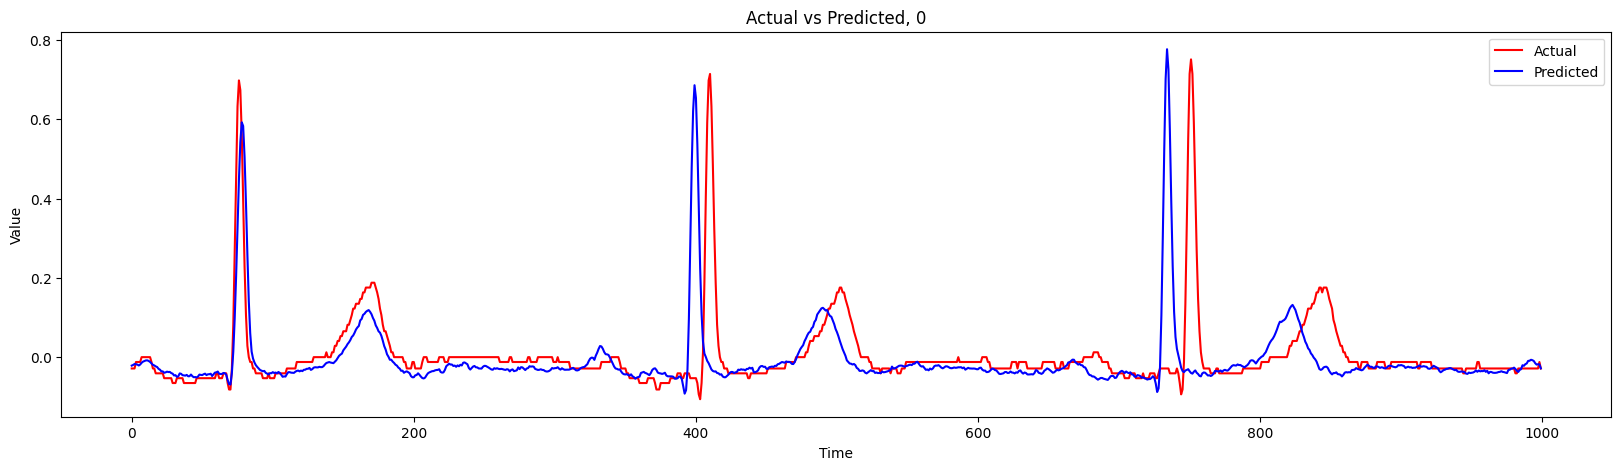

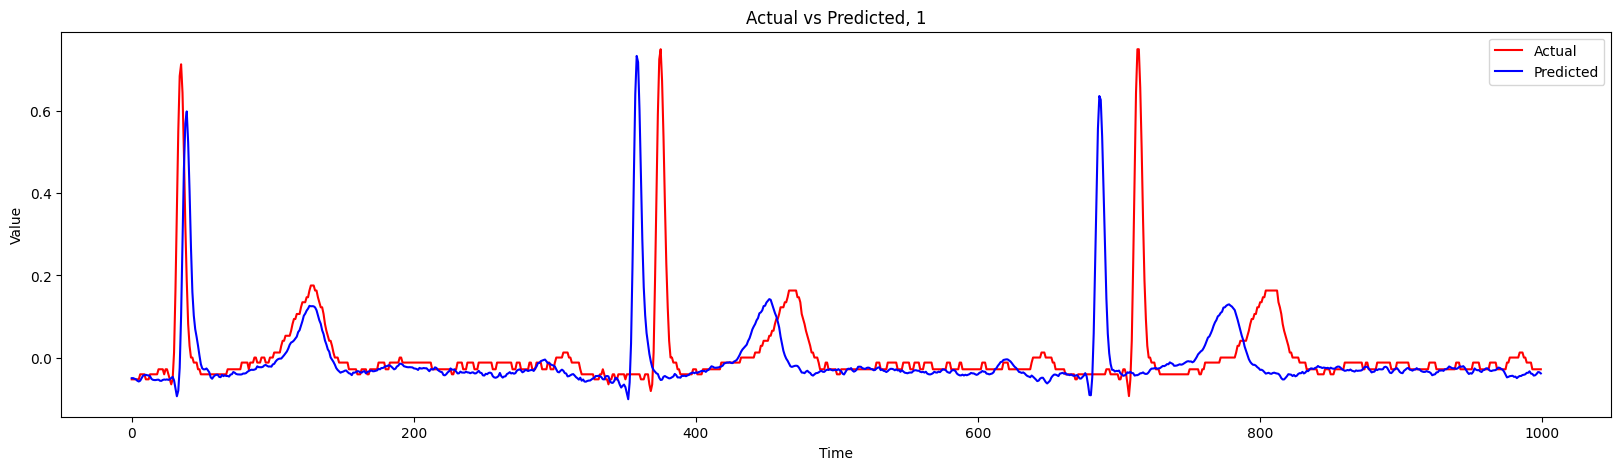

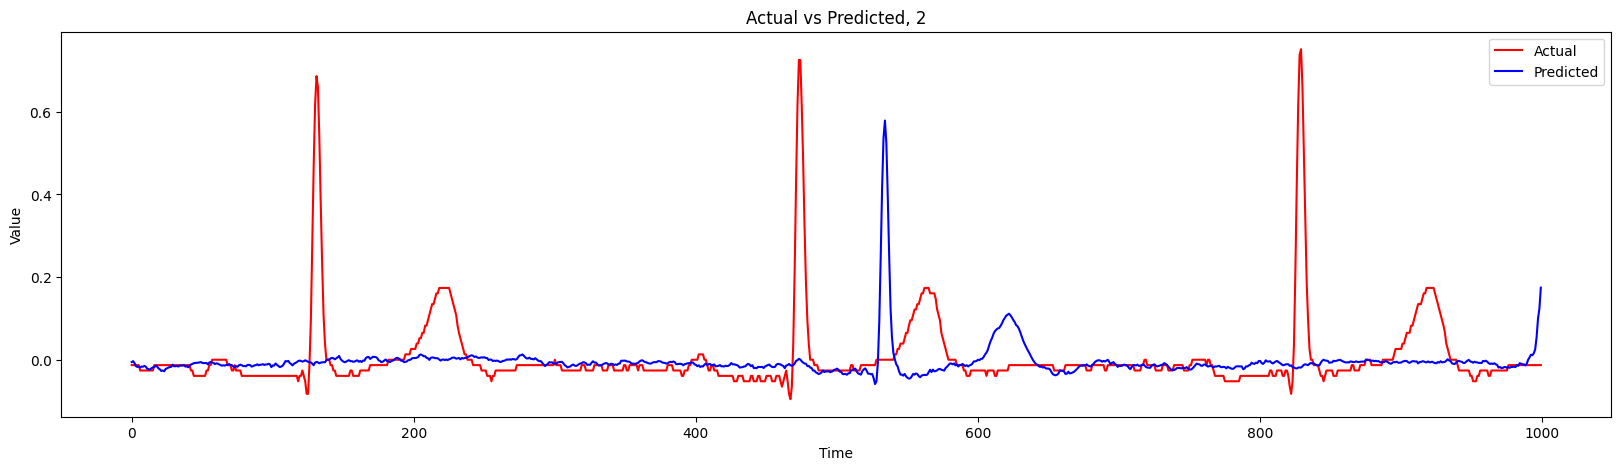

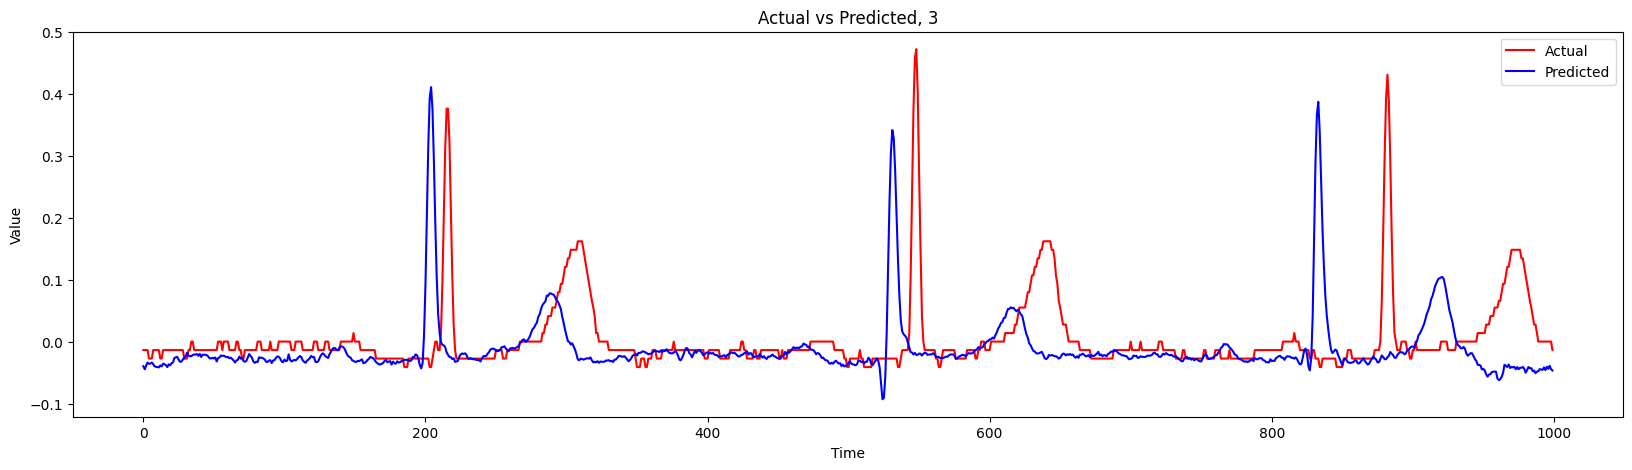

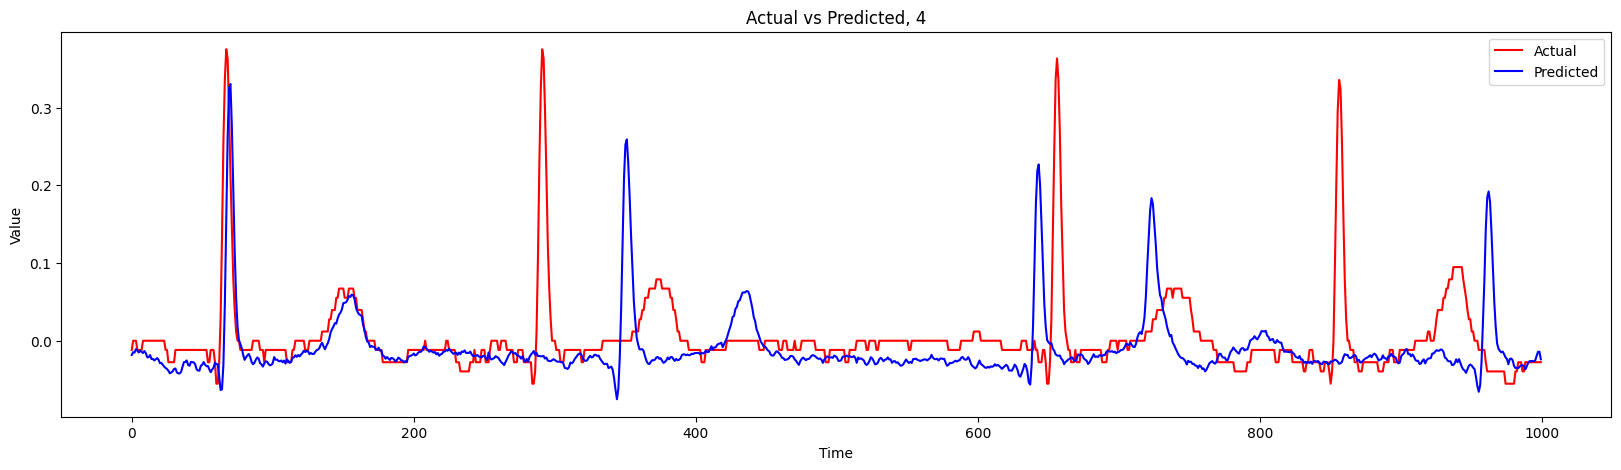

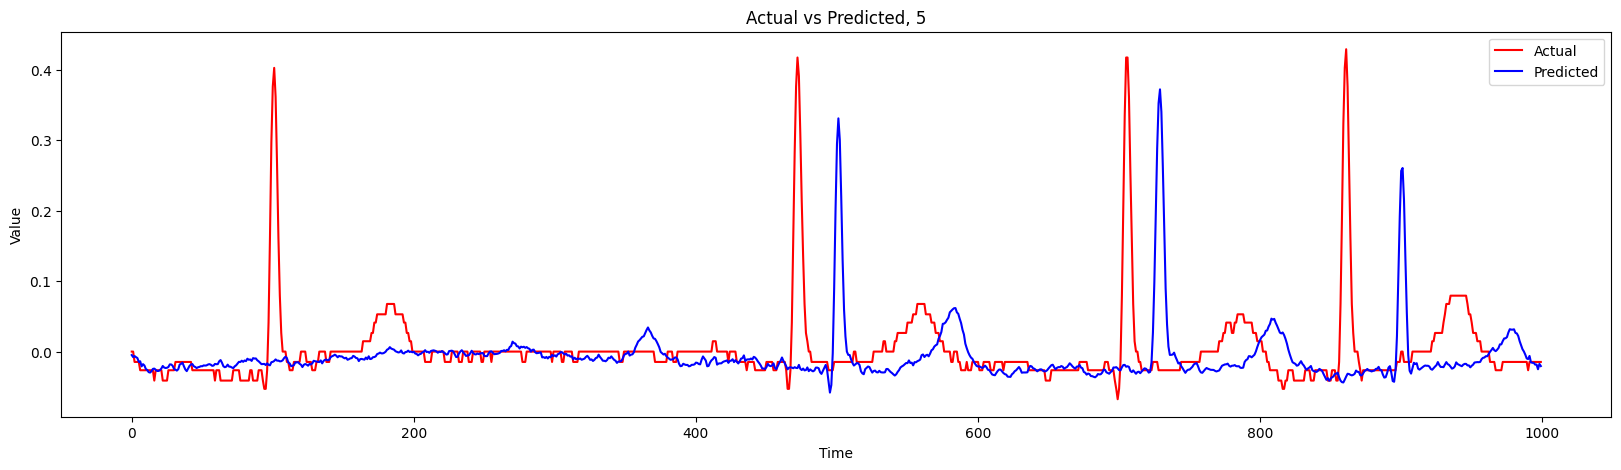

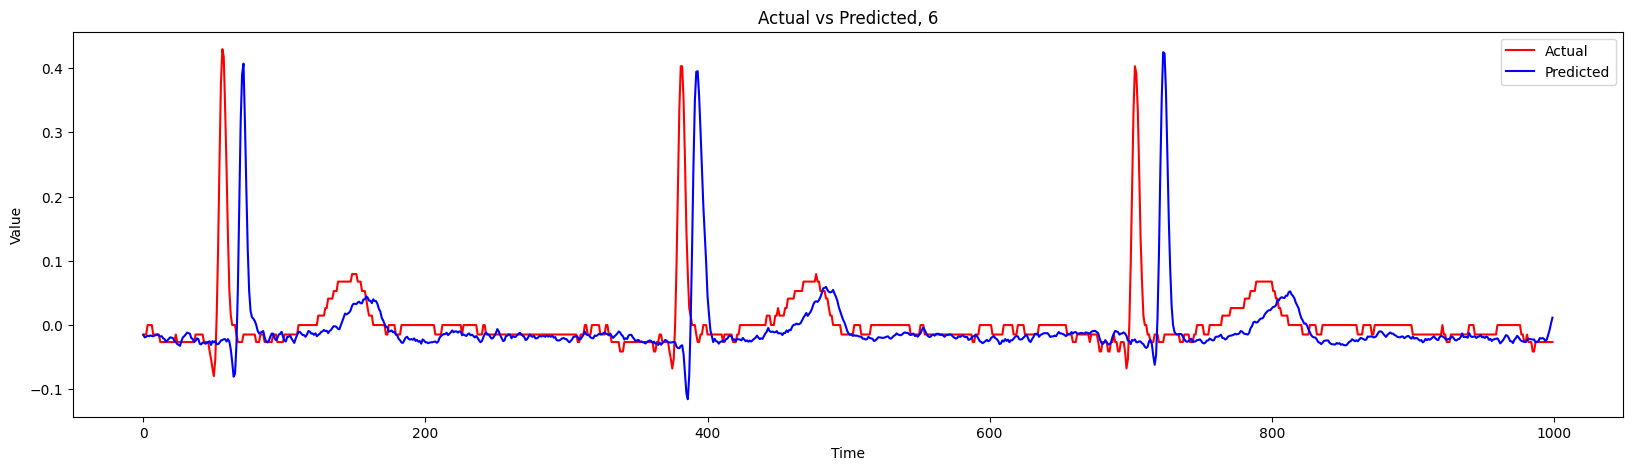

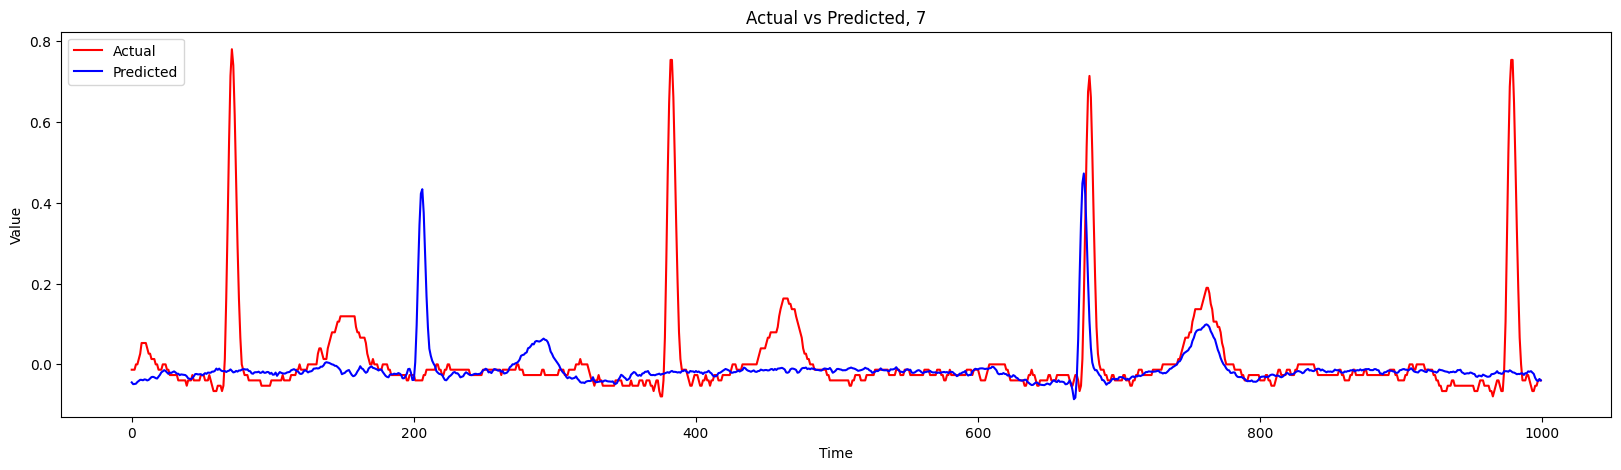

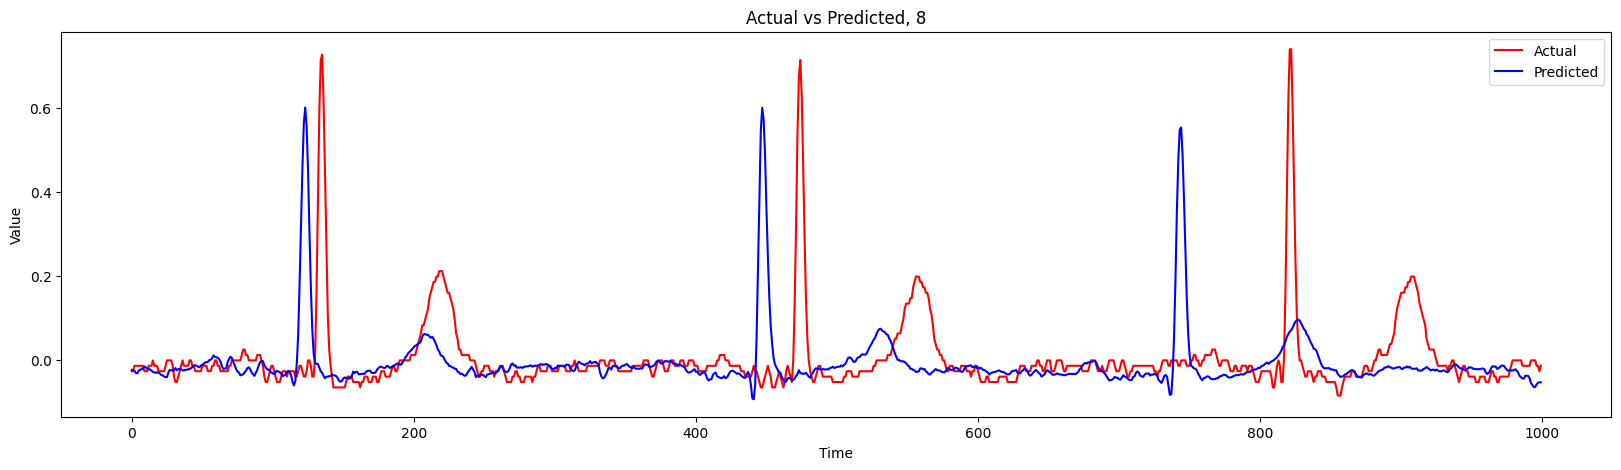

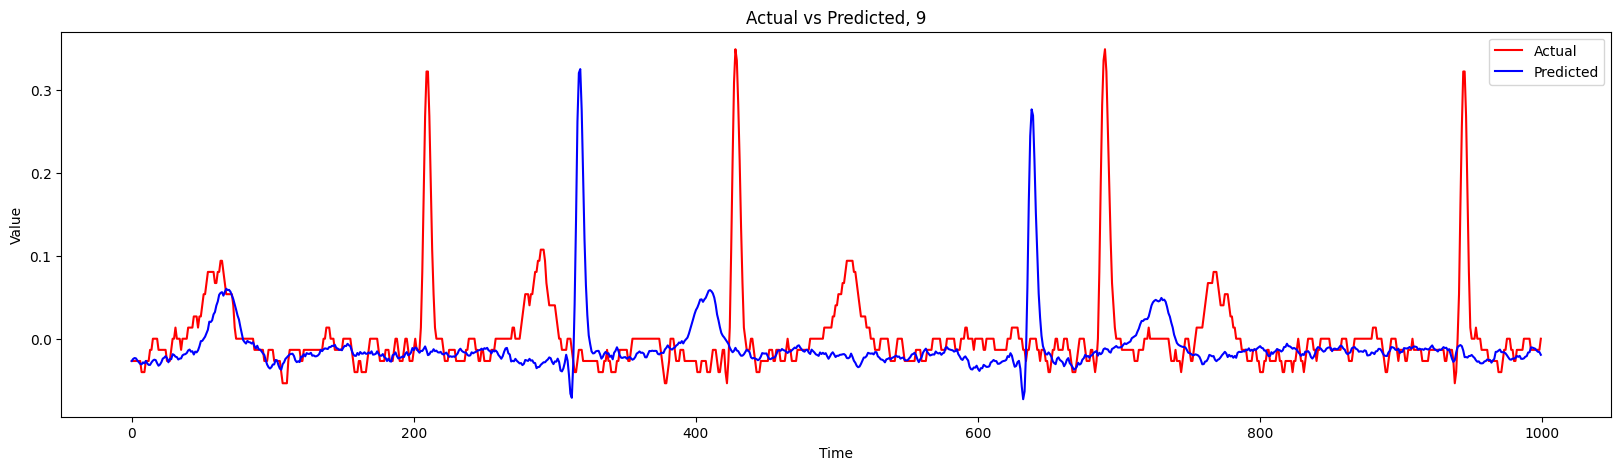

In [ ]:
import matplotlib.pyplot as plt
advance = context_window_size + label_window_size*0
duration = label_window_size
i = 0
for sample, pred in zip(data, predicted_ecg):
    # if i not in [2,4, 7]:
    #     i+=1
    #     continue
    sample = sample[advance : advance + duration]
    pred = pred[advance : advance + duration]
    visualize_prediction(actual=sample, predicted=pred, num=i)
    i+=1